In [1]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


**When we use Wald statistic to find estimation and its 95\%CI, we assume that sample size is large, thus $\hat{\lambda}$ will approximately have Chi-square or normal distribution (after taking square of root). If the sample size is small, the normal distribution may not be a good approximation. Two alternative approaches are (1) bootstrapping and (2) Bayesian method using MCMC algorithm to get a lot of samples from the ‘true’ distribution of $\lambda$, then we can find $\hat{\lambda}$ using sample-mean, sample-standard-deviation, sample-quantiles for 95\%CI. Also you can visualize the ‘true’ distribution of $\hat{\lambda}$ using histogram on those MCMC samples. A modification of example from the course notes (Page 60). $T_1,...,T_n$ iid exponential($\lambda$). The outcome is time to death from severe viral disease. The modified data are as follows (the same as HW3 Q2):**

**Steroid: 1(2), 1+(2), 4+, 5, 7, 8, 10, 10+, 12+, 16+(3)**

**Control: 1, 2, 3(2), 3+, 5+(2), 16+(8)**


**Find 95\% CI of $\hat{\lambda_i}$ (i = 1, 2) for each treatment group, using bootstrapping approach**

In [2]:
############## steroid group/data:
t1 <- c(1,1,1,1,4,5,7,8,10,10,12,16,16,16)
cen1 <- c(1,1,0,0,0,1,1,1,1,0,0,0,0,0)
sum(cen1)/sum(t1)  ##MLE of lambda
sum(t1)/sum(cen1)  ##MLE of mu

############## control group:
t2 <- c(1,2,3,3,3,5,5,rep(16,8))
cen2 <- c(1,1,1,1,0,0,0,rep(0,8))   
sum(cen2)/sum(t2)  ## MLE of lambda
sum(t2)/sum(cen2)  ## MLe of mu

[1] 0.05555556

[1] 18

[1] 0.02666667

[1] 37.5

Put the data in a nice data frame.

In [3]:
data = data.frame(
    time = c(t1, t2),
    cens = c(cen1, cen2),
    treatment = c(rep(1, length(t1)), rep(0, length(t2)))
)

head(data)

,time,cens,treatment
,<dbl>,<dbl>,<dbl>
1,1,1,1
2,1,1,1
3,1,0,1
4,1,0,1
5,4,0,1
6,5,1,1


Get the MLE of lambda for each group.

In [4]:
stats = data %>%
    group_by(treatment) %>%
    summarise(
        lambda_mle = sum(cens) / sum(time)
    )

stats

treatment,lambda_mle
<dbl>,<dbl>
0,0.02666667
1,0.05555556


To do the bootstrapping, we need to think about our generative model of the data. If we resample from the dataframe as a whole, that implies a generative model in which treatment assignment and outcome are both idd random variables. I think this is probably a bad model. It's not specified here, but usually for studies like this treatment and control are of fixed sizes. So, to reflect that, we should resample each group separately.

In [5]:
n_boots = 1000

treat_lambda_boot = rep(NA, n_boots)
control_lambda_boot = rep(NA, n_boots)

for (i in 1:n_boots) {
    control_lambda_boot[i] = data %>%
        filter(treatment == 0) %>%
        # resample the data with replacement
        sample_n(length(treatment), replace = TRUE) %>%
        # calculate lambda MLE
        summarise(lambda = sum(cens) / sum(time)) %>%
        pull(lambda)

    # replicate the above for the treatment group
    treat_lambda_boot[i] = data %>%
        filter(treatment == 1) %>%
        sample_n(length(treatment), replace = TRUE) %>%
        summarise(lambda = sum(cens) / sum(time)) %>%
        pull(lambda)
}

boot_samples = data.frame(
    control = control_lambda_boot,
    treat = treat_lambda_boot
)

head(boot_samples)

,control,treat
,<dbl>,<dbl>
1,0.02877698,0.05042017
2,0.04504505,0.05454545
3,0.02439024,0.06481481
4,0.04918033,0.04032258
5,0.01935484,0.06024096
6,0.04918033,0.04901961


In [6]:
# empirical CI for lambda in each group
treat_lambda_boot_ci = quantile(treat_lambda_boot, c(0.025, 0.975))
control_lambda_boot_ci = quantile(control_lambda_boot, c(0.025, 0.975))

treat_lambda_boot_ci
control_lambda_boot_ci


2.5%      97.5% 
0.02012107 0.12089768

2.5%       97.5% 
0.005262469 0.072074394

So, the 95% CI of $\hat{\lambda_i}$ for each treatment group is:

- **Treat Group:** [0.017857, 0.120713]
- **Control Group:** [0.004998, 0.075479]




Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


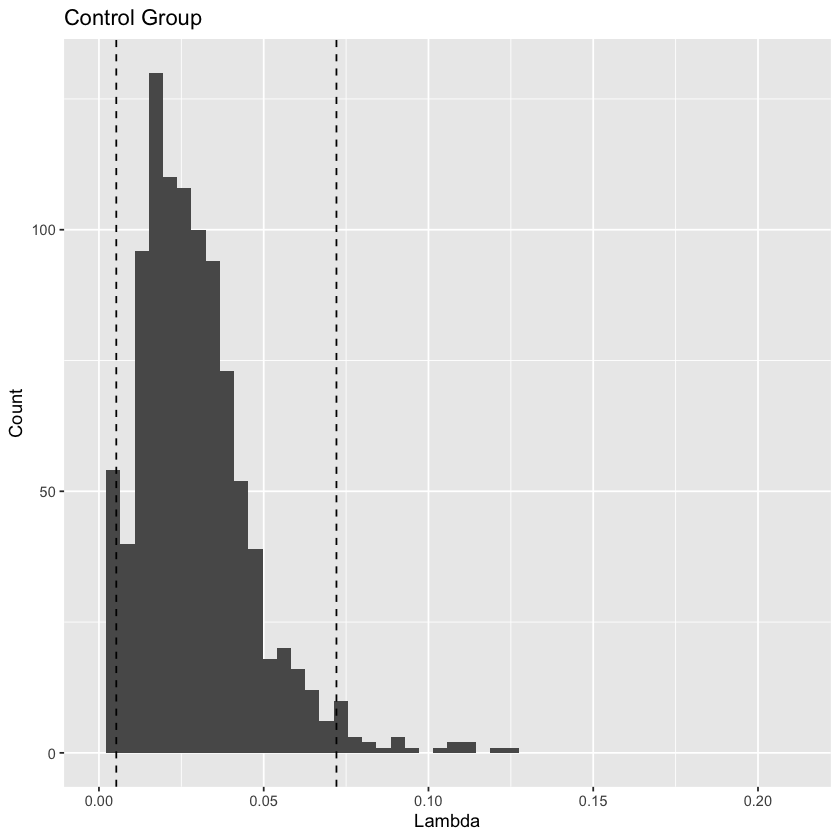

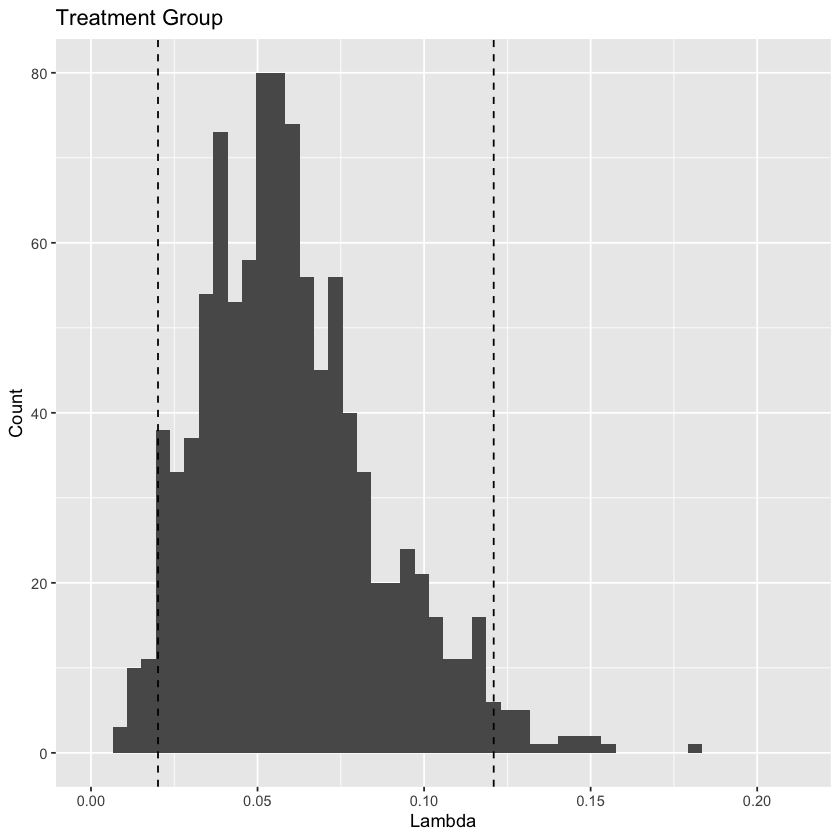

In [7]:
x_max = max(boot_samples$control, boot_samples$treat)

boot_samples %>%
    ggplot(aes(x = control)) +
    geom_histogram(bins = 50) +
    geom_vline(xintercept = control_lambda_boot_ci[1], color = "black", linetype = "dashed") +
    geom_vline(xintercept = control_lambda_boot_ci[2], color = "black", linetype = "dashed") +
    ggtitle("Control Group") +
    xlab("Lambda") +
    ylab("Count") +
    xlim(0, x_max)

boot_samples %>%
    ggplot(aes(x = treat)) +
    geom_histogram(bins = 50) +
    geom_vline(xintercept = treat_lambda_boot_ci[1], color = "black", linetype = "dashed") +
    geom_vline(xintercept = treat_lambda_boot_ci[2], color = "black", linetype = "dashed") +
    ggtitle("Treatment Group") +
    xlab("Lambda") +
    ylab("Count") +
    xlim(0, x_max)

**Find $\hat{\lambda_i}$ (i = 1, 2) and its 95\% CI for each treatment group, using Bayesian approach (you may use the R code below)**

In [8]:
##############log-likelihood

loglik <- function(lamda,y,ind){
	res.u <- sum(log(lamda*exp(-lamda*y[ind==1])))
	res.cen <- sum(log(exp(-lamda*y[ind==0])))
	return((res.u+res.cen))
}

###############MCMC 

mcmc.s <- function(y,ind,lam, e0, N)
{
	set.seed(99)
	opt <- rep(NA, N)
	for(i in 1:N) {
		old <- loglik(lam,y,ind)
		cand <- lam + e0 * rnorm(1)
		while(cand <0){cand <- lam + e0 * rnorm(1)}
		new <- loglik(cand,y,ind)
		if(log(runif(1)) < new - old) {
			lam <- cand
		}		
		opt[i] <- lam
}
	return(opt)
}

n_samples_mcmc = 10000

treat_lambda_mcmc = mcmc.s(y=t1,ind=cen1,lam=sum(cen1)/sum(t1) ,e0=0.09,n_samples_mcmc)
control_lambda_mcmc = mcmc.s(y=t2,ind=cen2,lam=sum(cen2)/sum(t2),e0=0.03,n_samples_mcmc)

mcmc_samples = data.frame(
    treat = treat_lambda_mcmc,
    control = control_lambda_mcmc
)

head(mcmc_samples)

,treat,control
,<dbl>,<dbl>
1,0.07481218,0.03308554
2,0.07481218,0.03308554
3,0.07481218,0.04640130
4,0.07604210,0.01840023
5,0.07604210,0.03308896
6,0.09677914,0.03308896


Did it converge?

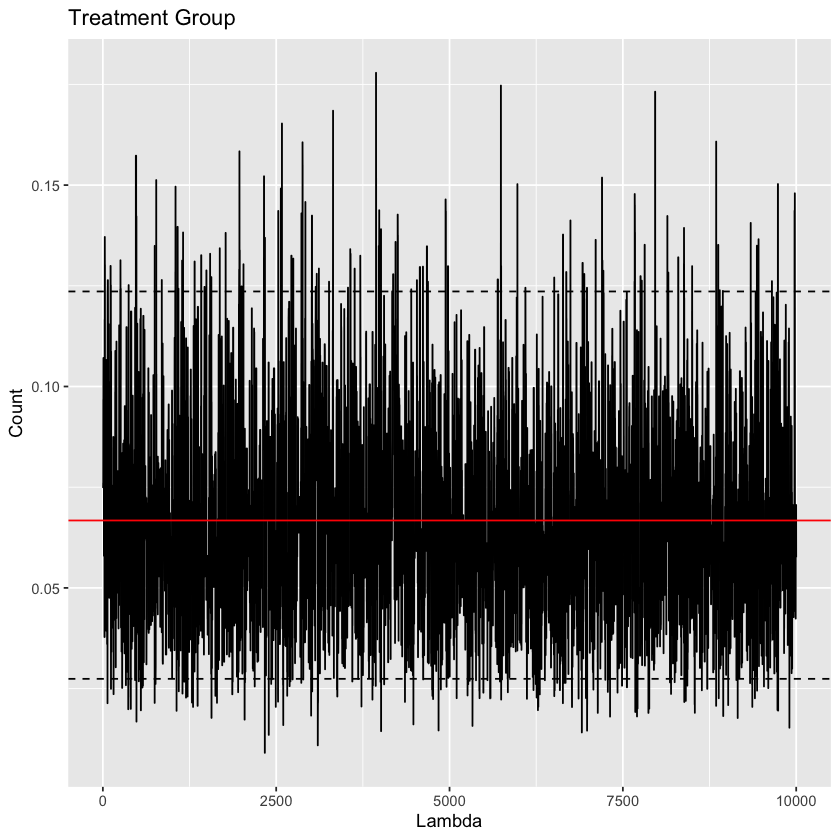

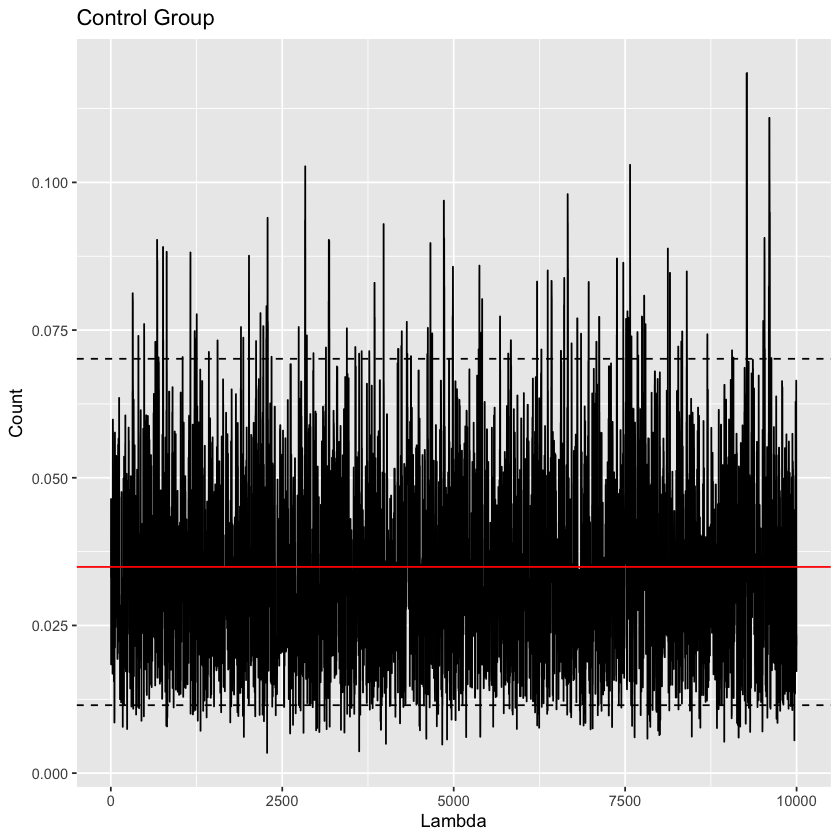

In [9]:
mcmc_samples %>%
    ggplot(aes(x = 1:n_samples_mcmc, y = treat)) +
    geom_line() +
    geom_hline(yintercept = quantile(treat_lambda_mcmc, c(0.025, 0.975)), color = "black", linetype = "dashed") +
    geom_hline(yintercept = mean(treat_lambda_mcmc), color = "red") +
    ggtitle("Treatment Group") +
    xlab("Lambda") +
    ylab("Count")

mcmc_samples %>%
    ggplot(aes(x = 1:n_samples_mcmc, y = control)) +
    geom_line() +
    geom_hline(yintercept = quantile(control_lambda_mcmc, c(0.025, 0.975)), color = "black", linetype = "dashed") +
    geom_hline(yintercept = mean(control_lambda_mcmc), color = "red") +
    ggtitle("Control Group") +
    xlab("Lambda") +
    ylab("Count")

These plots shows the MCMC chains for each group over the course of sampling, Dashed lines show the 95% quantile CI, and the red line shows the mean.

This looks healthy. It looks each chain is inhabiting a single high probability region. We're not seeing any phase changes or drift. We do get some occasional very high values, but that is to be expected exponential-ish/gamm-ish distributed variables.

In [10]:
mcmc_samples %>%
    pivot_longer(cols = everything(), names_to = "treatment", values_to = "lambda") %>%
    group_by(treatment) %>%
    summarise(
        mean_lambda = mean(lambda),
        sd_lambda = sd(lambda),
        ci_lower = quantile(lambda, 0.025),
        ci_upper = quantile(lambda, 0.975)
    )

treatment,mean_lambda,sd_lambda,ci_lower,ci_upper
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
control,0.03490707,0.01530470,0.01150058,0.07013802
treat,0.06673843,0.02427198,0.02742154,0.12359389


So, we find a posterior mean and 95% CI of hazard rate of:

- **Treat Group:** 0.06673843 [0.02742154,	0.12359389]
- **Control Group:** 0.03490707 [0.01150058,	0.07013802]

This is consistent with the MLE results (see below), where we found $\hat{\lambda_1} = 	0.0267$ and $\hat{\lambda_2} = 0.0556$.

In [11]:
stats

treatment,lambda_mle
<dbl>,<dbl>
0,0.02666667
1,0.05555556


We can also plot the posterior distribution of the hazard rate for each group. These look similar to the bootstrapped sampling distributions.

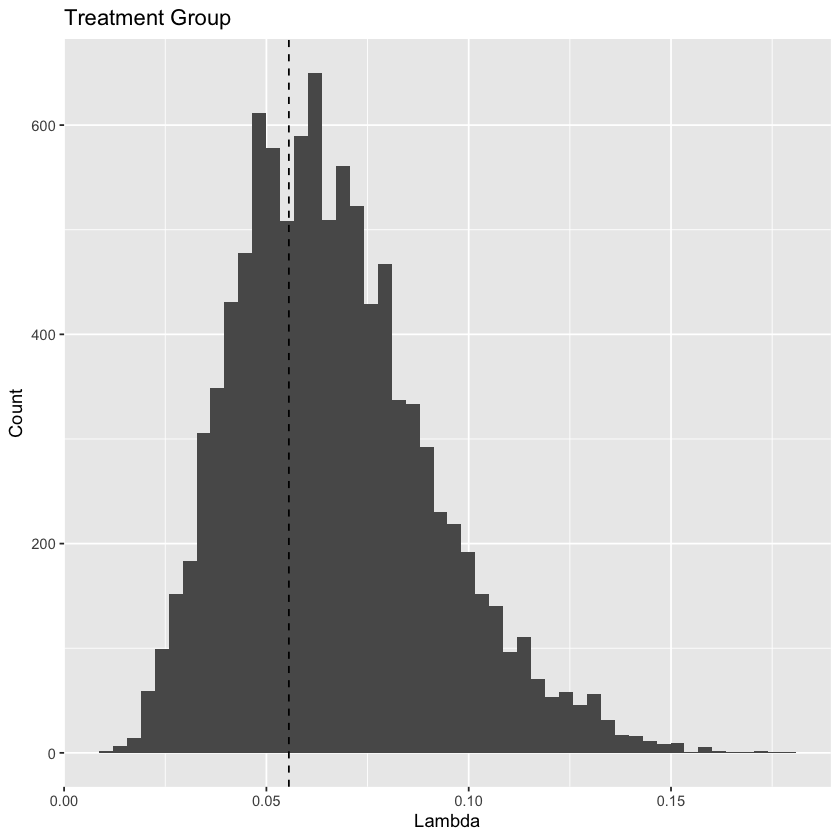

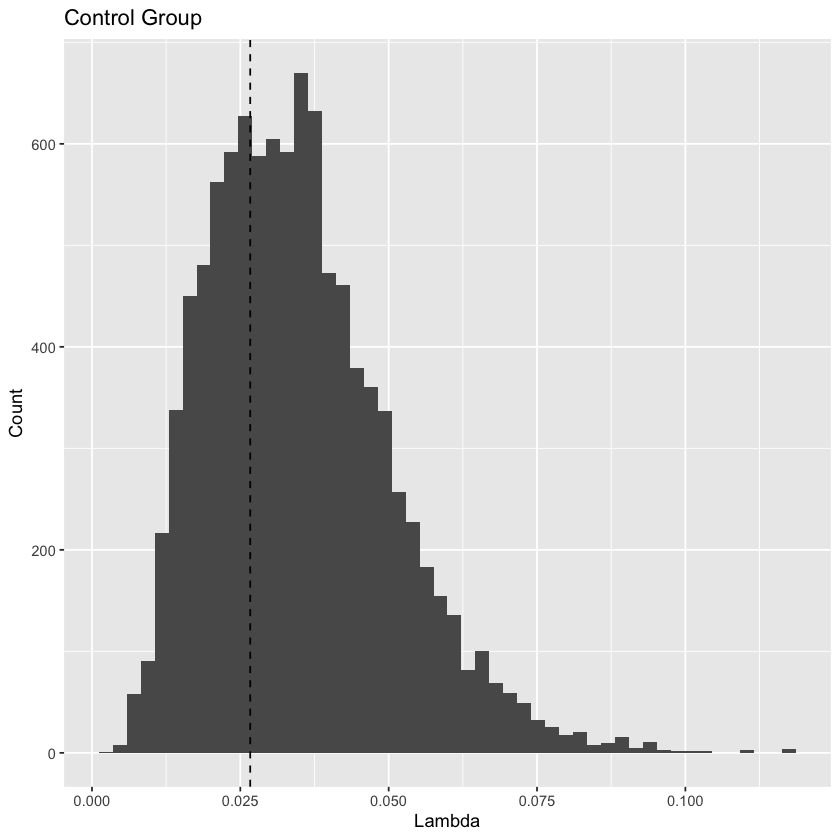

In [12]:
mcmc_samples %>%
    ggplot(aes(x = treat)) +
    geom_histogram(bins = 50) +
    geom_vline(xintercept = sum(cen1)/sum(t1), color = "black", linetype = "dashed") +
    ggtitle("Treatment Group") +
    xlab("Lambda") +
    ylab("Count")

mcmc_samples %>%
    ggplot(aes(x = control)) +
    geom_histogram(bins = 50) +
    geom_vline(xintercept = sum(cen2)/sum(t2), color = "black", linetype = "dashed") +
    ggtitle("Control Group") +
    xlab("Lambda") +
    ylab("Count")

**Based on (a) and (b), estimate hazard ratio between two groups (HR = $\lambda_1/\lambda_2$)**

From the MCMC process, we have samples from the joint posterior distribution of $\lambda_1$ and $\lambda_2$. We can just take the ratio of the two vectors to get samples from the posterior distribution of the hazard ratio. Then, we can take the posterior mean and median to get the Bayes estimators for squared and absolute loss.

In [13]:
mcmc_samples = mcmc_samples %>%
    mutate(hr = treat / control)

hr_bayes_estimators = mcmc_samples %>%
    summarise(
        mean_hr = mean(hr),
        median_hr = median(hr),
    )

hr_bayes_estimators

mean_hr,median_hr
<dbl>,<dbl>
2.373947,1.959239


So, the Bayes estimators for the hazard ratio are:

- **Mean:** 2.373947
- **Median:** 1.959239

A more interesting question possibly is whether we're confident which group had higher hazard. We can approach this problem by counting the proportion of posterior samples that are greater than 1.

In [14]:
mean(mcmc_samples$hr > 1)

[1] 0.8704

So, there's an 87% posterior probability that the treatment group has higher hazard. This is not a very confident answer. In frequentist statistics, we typically demand >95% confidence for the equivalent question to make a claim.

We plot the posterior distribution of the hazard ratio below. We can see that there's significant uncertainty.

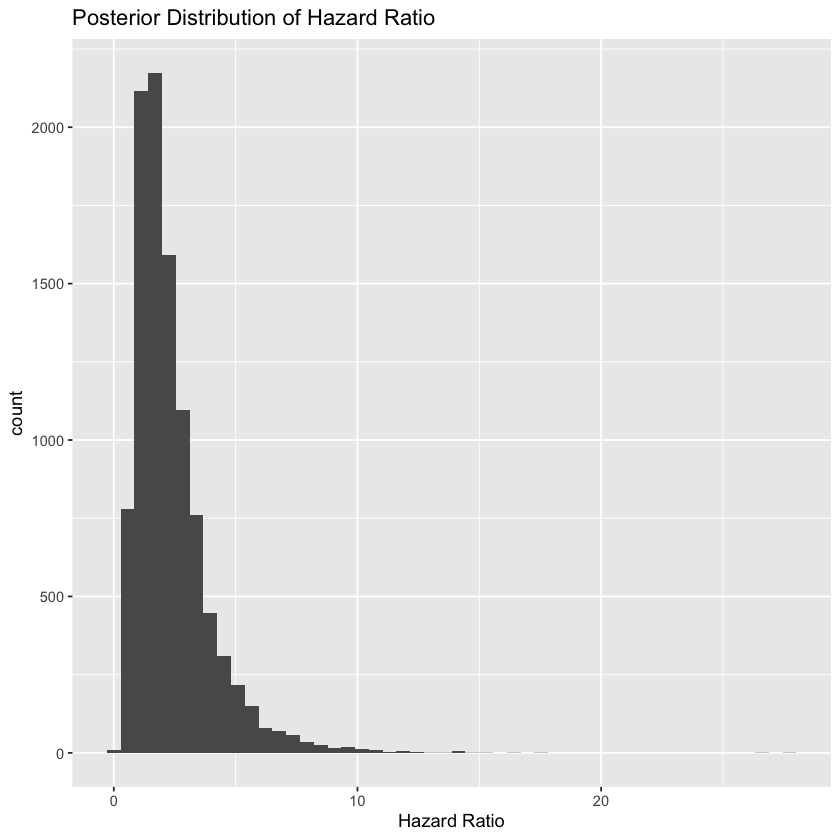

In [15]:
mcmc_samples %>%
    ggplot(aes(x = hr)) +
    geom_histogram(bins = 50) +
    ggtitle("Posterior Distribution of Hazard Ratio") +
    xlab("Hazard Ratio")

**Estimate a 95\% CI of hazard ratio using either bootstrapping or Bayesian approach.**

In [16]:
mcmc_samples %>%
    summarise(
        ci_lower = quantile(hr, 0.025),
        ci_upper = quantile(hr, 0.975)
    )

ci_lower,ci_upper
<dbl>,<dbl>
0.6278815,6.63122


In [17]:
boot_samples %>%
    mutate(hr = treat / control) %>%
    summarise(
        ci_lower = quantile(hr, 0.025),
        ci_upper = quantile(hr, 0.975)
    )

ci_lower,ci_upper
<dbl>,<dbl>
0.5088918,12.3567


So, the 95% CI of the hazard ratio is:

- **Bootstrapping:** [0.4938671,	13.32642]
- **Bayesian:** [0.6278815,	6.63122]

The Bayes CI is narrower, but neither is very confident. Both include values well above and below 1. So, the statistical conclusion here is that althouh it seems likely that treatment is harmful (87% posterior probability), we don't have enough data to make a truly confident claim either way.